In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from keras import backend as K
from tensorflow import keras
from keras import layers
import time
import glob
import imageio
from collections import defaultdict
from PIL import Image

In [2]:
path = '/content/Dataset'
if not os.path.exists(path):
    ! unzip Dataset
else: 
    print('Already Extracted')

Already Extracted


In [3]:
# Load the data
data_dir = '/content/Dataset'
class_names = ['1', '2', '3', '4', '5']
num_classes = len(class_names)

# Create a function to load the data
def load_data(data_dir, class_names):
    images = []
    labels = []
    for class_name in class_names:
        class_dir = data_dir + '/' + 'Class ' + class_name
        for image_path in tf.io.gfile.glob(class_dir + '/*.png'):
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) #, cv2.IMREAD_GRAYSCALE
            images.append(img)
            labels.append(class_names.index(class_name) + 1)
    return np.array(images), np.array(labels)

In [4]:
# Load the data
images, labels = load_data(data_dir, class_names)

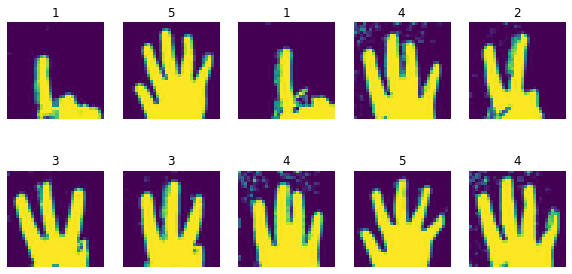

In [5]:
# Visualize the data
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()
i = 0
for num in (np.random.randint(0, len(images), 10)):
    axes[i].imshow(images[num])
    axes[i].set_title(labels[num])
    axes[i].axis('off')
    i += 1
plt.show()

In [6]:
print('Images shape:', images.shape)
print(images.shape[0], 'train samples')

Images shape: (1005, 32, 32)
1005 train samples


In [7]:
np.random.seed(1337)
num_classes = 5

epochs = 30
latent_dim = 128

adam_lr = 0.0002
adam_beta_1 = 0.5

In [8]:
def build_generator(latent_size):
    cnn = tf.keras.Sequential()

    cnn.add(layers.Dense(8 * 8 * 128, input_dim=latent_size))
    cnn.add(layers.LeakyReLU(alpha=0.2))
    cnn.add(layers.Reshape((8, 8, 128)))

    cnn.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same',
                          kernel_initializer='glorot_normal'))
    cnn.add(layers.LeakyReLU(alpha=0.2))
    cnn.add(layers.BatchNormalization())

    cnn.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same',
                          kernel_initializer='glorot_normal'))
    cnn.add(layers.LeakyReLU(alpha=0.2))
    cnn.add(layers.BatchNormalization())

    cnn.add(layers.Conv2D(1, 7, padding='same',
                          activation='tanh',
                          kernel_initializer='glorot_normal'))
    
    return cnn

In [9]:
print('Generator model:')
generator = build_generator(latent_dim)
generator.summary()

Generator model:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              1056768   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                         

In [10]:
def build_discriminator():

    cnn = tf.keras.Sequential()

    cnn.add(layers.Conv2D(32, 3, padding='same', strides=2,
                          input_shape=(32, 32, 1)))
    cnn.add(layers.LeakyReLU(0.2))
    cnn.add(layers.Dropout(0.3))

    cnn.add(layers.Conv2D(64, 3, padding='same', strides=1))
    cnn.add(layers.LeakyReLU(0.2))
    cnn.add(layers.Dropout(0.3))

    cnn.add(layers.Conv2D(128, 3, padding='same', strides=2))
    cnn.add(layers.LeakyReLU(0.2))
    cnn.add(layers.Dropout(0.3))

    cnn.add(layers.Conv2D(256, 3, padding='same', strides=1))
    cnn.add(layers.LeakyReLU(0.2))
    cnn.add(layers.Dropout(0.3))
    
    cnn.add(layers.GlobalMaxPooling2D()),
    cnn.add(layers.Dense(1))
    
    return cnn

In [11]:
print('Discriminator model:')
discriminator = build_discriminator()
discriminator.summary()

Discriminator model:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (Non

In [12]:

class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [13]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/content/images/generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

In [14]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

In [15]:
batch_size = 64
images = images.astype("float32") / 255
images = np.expand_dims(images, axis=3)
dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

In [17]:
hist = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/30
16/16 [==============================] - 9s 107ms/step - d_loss: 0.6304 - g_loss: 0.6900
Epoch 2/30
16/16 [==============================] - 1s 49ms/step - d_loss: 0.4582 - g_loss: 0.8143
Epoch 3/30
16/16 [==============================] - 1s 52ms/step - d_loss: 0.3688 - g_loss: 0.9580
Epoch 4/30
16/16 [==============================] - 1s 52ms/step - d_loss: 0.1939 - g_loss: 1.5791
Epoch 5/30
16/16 [==============================] - 1s 51ms/step - d_loss: 0.3595 - g_loss: 1.7816
Epoch 6/30
16/16 [==============================] - 1s 51ms/step - d_loss: 0.4114 - g_loss: 1.3055
Epoch 7/30
16/16 [==============================] - 1s 51ms/step - d_loss: 0.4503 - g_loss: 1.2332
Epoch 8/30
16/16 [==============================] - 1s 53ms/step - d_loss: 0.5453 - g_loss: 1.0926
Epoch 9/30
16/16 [==============================] - 1s 54ms/step - d_loss: 0.6070 - g_loss: 0.9452
Epoch 10/30
16/16 [==============================] - 1s 50ms/step - d_loss: 0.5979 - g_loss: 0.9052
Epoch 11

In [18]:
# list all data in history
print(hist.history.keys())

dict_keys(['d_loss', 'g_loss'])


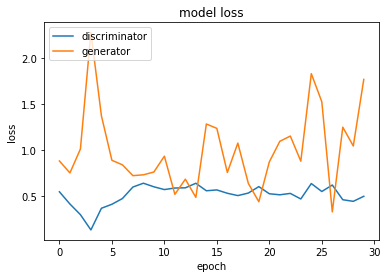

In [19]:
plt.plot(hist.history['d_loss'])
plt.plot(hist.history['g_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['discriminator', 'generator'], loc='upper left')
plt.show()

In [20]:
!zip -r /content/file.zip /content/images

  adding: content/images/ (stored 0%)
  adding: content/images/generated_img_0_2.png (stored 0%)
  adding: content/images/generated_img_1_10.png (stored 0%)
  adding: content/images/generated_img_2_5.png (stored 0%)
  adding: content/images/generated_img_1_17.png (stored 0%)
  adding: content/images/generated_img_2_24.png (stored 0%)
  adding: content/images/generated_img_2_15.png (stored 0%)
  adding: content/images/generated_img_1_21.png (stored 0%)
  adding: content/images/generated_img_1_27.png (stored 0%)
  adding: content/images/generated_img_1_24.png (stored 0%)
  adding: content/images/generated_img_2_23.png (stored 0%)
  adding: content/images/generated_img_0_4.png (stored 0%)
  adding: content/images/generated_img_0_0.png (stored 0%)
  adding: content/images/generated_img_1_16.png (stored 0%)
  adding: content/images/generated_img_0_12.png (stored 0%)
  adding: content/images/generated_img_0_11.png (stored 0%)
  adding: content/images/generated_img_1_11.png (stored 0%)
  addi